In [1]:
import torch
import pandas as pd
import numpy as np
from torch import nn
import os
import sklearn
import matplotlib.pyplot as plt
import sys

In [2]:
path = "/Users/jm/VS Code/ML/Time Series Prediction/N_TXT"

os.chdir(path)

fx_data = np.array([], dtype=np.float32)

#gets data from file specified by file_path
def get_contents(file_path):
    global fx_data
    skip_lines = 7

    with open(file_path,'r') as file:

        for skips in range(skip_lines):
            next(file)

        lines = file.readlines()[:-1]

        for line in lines:
            data = line.split()[-1]
            fx_data = np.append(fx_data, np.float32(data))
            #print(data)

In [3]:
#go through all files in directory and extract data from txt files
for file in os.listdir():
    if file.endswith(".txt"):
        file_path = f"{path}/{file}"
        print(f"Currently working on: {file_path}")
        get_contents(file_path)

fx_data.dtype

Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/9Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/8Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/1Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/3Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/10Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/2Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/11Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/7Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/6Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/4Npie.txt
Currently working on: /Users/jm/VS Code/ML/Time Series Prediction/N_TXT/5Npie.txt


dtype('float32')

In [4]:
#create time "sample" for dataframe
time_data = np.array([], dtype=np.float32)

for x in range(len(fx_data)):
    time_data = np.append(time_data, np.float32(x))
    type(x)

time_data, time_data[0].dtype

(array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.87857e+05,
        1.87858e+05, 1.87859e+05], dtype=float32),
 dtype('float32'))

In [5]:
#create time "sample" for dataframe
dataset = pd.DataFrame({"Time": time_data,
                        "FX Channel": fx_data})
dataset

,Time,FX Channel
0,0.0,-0.6
1,1.0,-0.6
2,2.0,-0.6
3,3.0,-0.6
4,4.0,-0.6
...,...,...
187855,187855.0,4.1
187856,187856.0,4.1
187857,187857.0,4.1
187858,187858.0,4.1


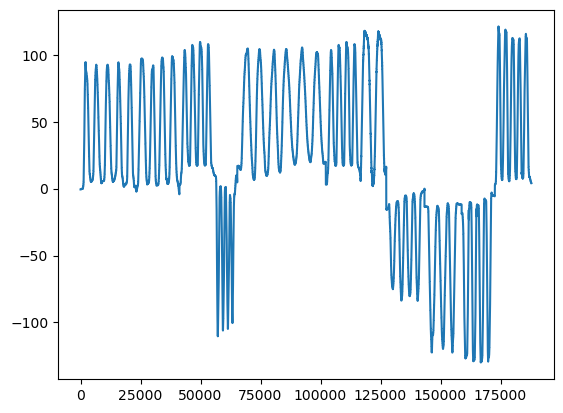

In [6]:
plt.plot(dataset["FX Channel"])

In [7]:
dataset.iloc[:, 1]

0        -0.6
1        -0.6
2        -0.6
3        -0.6
4        -0.6
         ... 
187855    4.1
187856    4.1
187857    4.1
187858    4.1
187859    4.1
Name: FX Channel, Length: 187860, dtype: float32

In [8]:
dataset["FX Channel"].shape, type(dataset["FX Channel"])

((187860,), pandas.core.series.Series)

In [9]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

#split into train, test and validation, convert PD series to numpy first before train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset["Time"].to_numpy(), dataset["FX Channel"].to_numpy(), test_size = 0.2, random_state=RANDOM_SEED)

X_train.size, X_test.size, X_train.shape, X_test.shape

(150288, 37572, (150288,), (37572,))

In [10]:
#reshape X_train and y_train so that we can use scaler from sklearn
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
X_test.shape, X_train.shape, y_train.shape

((37572, 1), (150288, 1), (150288,))

In [11]:
from sklearn import preprocessing

#scale and normalize data
scaler = preprocessing.StandardScaler()

scaler.fit_transform(X_train)
scaler.fit_transform(X_test)

array([[ 0.2881603 ],
       [-0.8517299 ],
       [-0.04598645],
       ...,
       [ 0.6411164 ],
       [-1.186853  ],
       [ 1.4533998 ]], dtype=float32)

In [12]:
#set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
#convert data from numpy to tensors
X_train = torch.from_numpy(X_train).type(torch.float32)
X_test = torch.from_numpy(X_test).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.float32)
y_test = torch.from_numpy(y_test).type(torch.float32)

In [14]:
type(X_train), X_train.dtype

(torch.Tensor, torch.float32)

In [15]:
dataset

,Time,FX Channel
0,0.0,-0.6
1,1.0,-0.6
2,2.0,-0.6
3,3.0,-0.6
4,4.0,-0.6
...,...,...
187855,187855.0,4.1
187856,187856.0,4.1
187857,187857.0,4.1
187858,187858.0,4.1


In [16]:
time_data.shape, fx_data.shape, fx_data.shape[0]

((187860,), (187860,), 187860)

In [17]:
#send data to device
X_train = X_train.to(device).type(torch.float32) 
X_test = X_test.to(device).type(torch.float32) 
y_test = y_test.to(device).type(torch.float32) 
y_train = y_train.to(device).type(torch.float32) 

In [18]:
#trying to split data loader now? not too sure if this is the best way
split_idx = int(0.8 * len(dataset))

train_data = dataset[:split_idx]
test_data = dataset[split_idx:]

train_data.size, test_data.size, train_data["FX Channel"], train_data["Time"]

(300576,
 75144,
 0         -0.600000
 1         -0.600000
 2         -0.600000
 3         -0.600000
 4         -0.600000
             ...    
 150283   -90.599998
 150284   -90.699997
 150285   -90.800003
 150286   -90.900002
 150287   -90.900002
 Name: FX Channel, Length: 150288, dtype: float32,
 0              0.0
 1              1.0
 2              2.0
 3              3.0
 4              4.0
             ...   
 150283    150283.0
 150284    150284.0
 150285    150285.0
 150286    150286.0
 150287    150287.0
 Name: Time, Length: 150288, dtype: float32)

In [20]:
# time_data.to(device)
# fx_data.to(device)
# time_data.shape, time_data[7].size, fx_data[0].size

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [21]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from pathlib import Path

split_idx = int(0.8 * len(fx_data))
print(f"{split_idx}")

#convert data to use for dataloader
class FX_train_dataset(Dataset):
    def __init__(self):
        self.x = torch.from_numpy(time_data[:split_idx])
        self.y = torch.from_numpy(fx_data[:split_idx])
        self.n_samples = split_idx

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
#convert data to use for dataloader
class FX_test_dataset(Dataset):
    def __init__(self):
        self.x = torch.from_numpy(time_data[split_idx:])
        self.y = torch.from_numpy(fx_data[split_idx:])
        self.n_samples = fx_data.shape[0] - split_idx

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

150288


In [22]:
train_data = FX_train_dataset()
test_data = FX_test_dataset()

len(train_data), train_data[0], train_data[100000]

(150288, (tensor(0.), tensor(-0.6000)), (tensor(100000.), tensor(51.7000)))

In [23]:
for x in range(10):
    print(f"{train_data[x]}\n")

(tensor(0.), tensor(-0.6000))

(tensor(1.), tensor(-0.6000))

(tensor(2.), tensor(-0.6000))

(tensor(3.), tensor(-0.6000))

(tensor(4.), tensor(-0.6000))

(tensor(5.), tensor(-0.6000))

(tensor(6.), tensor(-0.6000))

(tensor(7.), tensor(-0.6000))

(tensor(8.), tensor(-0.6000))

(tensor(9.), tensor(-0.6000))



In [35]:
from torch.utils.data import DataLoader

#setup batch size hyperparameter
BATCH_SIZE = 16

#turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False)

#check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of train_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x32a9569b0>, <torch.utils.data.dataloader.DataLoader object at 0x32d4b1570>)
Length of train_dataloader: 9393 batches of 16
Length of train_dataloader: 2349 batches of 16


In [36]:
type(train_dataloader)

torch.utils.data.dataloader.DataLoader

In [37]:
# #checkout whats inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape


(torch.Size([16]), torch.Size([16]))

In [38]:
#set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [39]:
X_train.dtype

torch.float32

In [40]:
"""
Model definition
"""
class RNN(nn.Module):
    """
    Basic RNN block. This represents a single layer of RNN
    """
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        """
        input_size: Number of features of your input vector
        hidden_size: Number of hidden neurons
        output_size: Number of features of your output vector
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = 16

        self.i2h = nn.Linear(input_size, hidden_size, bias=False)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)


    def forward(self, x, hidden_state) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns softmax(linear_out) and tanh(i2h + i2o)
        Inputs
        ------
        x: Input vector x  with shape (vocab_size, )
        hidden_state: Hidden state matrix
        Outputs
        -------
        out: Prediction vector
        hidden_state: New hidden state matrix
        """
        x = self.i2h(x)
       # print(f"X rnn shape: {x.shape}")
        hidden_state = self.h2h(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
       # print(f"hidden_Staete shape: {hidden_state.shape}")
        return self.h2o(hidden_state), hidden_state

    def init_zero_hidden(self, batch_size=1) -> torch.Tensor:
        """
        Returns a hidden state with specified batch size. Defaults to 1
        """
        return torch.zeros(batch_size, self.hidden_size, requires_grad=False)

In [41]:
rnn = RNN(input_size = 1,
          hidden_size = 16,
          output_size = 1,
         ).to(device)

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(params=rnn.parameters(),
                             lr = 0.1)

In [52]:
def training_loop(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                epochs: int,
                optimizer: torch.optim,
                loss_fn: torch.optim.Optimizer):
    train_loss = {}
    model.to(device)

    #set to train
    model.train()

    for epoch in range(epochs):
        epoch_loss = list()

        loss = 0

        for batch, (X, y) in enumerate(train_dataloader):

            hidden = torch.zeros(1, 1, 8) 

            #print(f"X shape: {X.shape}")

            X, y, hidden = X.to(device).reshape(1, 16,1), y.to(device), hidden.to(device)
            #make pred
            y_pred, hidden = model(X, hidden)

            #calc loss
            loss += loss_fn(y_pred, y)

            #optim zero grad
            model.zero_grad()

        #back prop
        loss.backward()

        #optim step
        nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

        epoch_loss.append(loss.detach().item() / len(train_dataloader))

        train_loss[epoch] = torch.tensor(epoch_loss).mean()

        print(f"epoch: {epoch} | loss: {train_loss[epoch]}")

In [43]:
X_train.type, X_train.dtype

(<function Tensor.type>, torch.float32)

In [44]:
EPOCHS = 1000

training_loop(model=rnn,
              dataloader=train_dataloader,
              epochs = EPOCHS,
              optimizer=optimizer,
              loss_fn=loss_fn)

/Users/jm/miniforge3/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([1, 16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0 | loss: 3699.85693359375
epoch: 1 | loss: 3594.262451171875
epoch: 2 | loss: 3494.43701171875
epoch: 3 | loss: 3406.49853515625
epoch: 4 | loss: 3325.035400390625
epoch: 5 | loss: 3246.765625
epoch: 6 | loss: 3172.5693359375
epoch: 7 | loss: 3102.92431640625
epoch: 8 | loss: 3038.14697265625
epoch: 9 | loss: 2978.4560546875
epoch: 10 | loss: 2924.02490234375
epoch: 11 | loss: 2874.9228515625
epoch: 12 | loss: 2831.26318359375
epoch: 13 | loss: 2793.111572265625
epoch: 14 | loss: 2760.50634765625
epoch: 15 | loss: 2733.4833984375
epoch: 16 | loss: 2712.090576171875
epoch: 17 | loss: 2696.350830078125
epoch: 18 | loss: 2686.27978515625
epoch: 19 | loss: 2681.904541015625
epoch: 20 | loss: 2683.223876953125
epoch: 21 | loss: 2688.17626953125
epoch: 22 | loss: 2694.10205078125
epoch: 23 | loss: 2699.360107421875
epoch: 24 | loss: 2703.1005859375
epoch: 25 | loss: 2704.926025390625
epoch: 26 | loss: 2704.84619140625
epoch: 27 | loss: 2703.0703125
epoch: 28 | loss: 2699.980224609375

KeyboardInterrupt: 

In [45]:
  # Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [46]:
predictions = np.array([])

# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            global predictions

            hidden = model.init_zero_hidden(batch_size=model.batch_size)

            # Send data to the target device
            X, y, hidden = X.reshape(1, len(X), 1).to(device), y.reshape(1, len(X), 1).to(device), hidden

            y_pred = model(X, hidden)
            print(f"y pred shape: {y_pred}")
            predictions = np.append(predictions, y_pred)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [47]:
eval_model(model=rnn,
           data_loader= test_dataloader,
           loss_fn = loss_fn,
           accuracy_fn=accuracy_fn,
           device=device)

y pred shape: (tensor([[[31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048],
         [31.0048]]]), tensor([[[ 1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
           1., -1.],
         [ 1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
           1., -1.],
         [ 1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
           1., -1.],
         [ 1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
           1., -1.],
         [ 1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
           1., -1.],
         [ 1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
           1., -1.],
         [ 1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (2, 1, 16) + inhomogeneous part.

In [48]:
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(20, 15))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

In [ ]:
plot_predictions(X_train.cpu().numpy(), y_train.cpu().numpy(), X_test.cpu().numpy(), y_test.cpu().numpy(), predictions=predictions)

In [55]:
#testing a different model
# number of points
num_time_steps = len(fx_data)
hidden_size = 8
input_size = 1
output_size = 1
lr = 0.1


class RNN_Model(nn.Module):
    def __init__(self):
        super(RNN_Model, self).__init__()

        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            # use batch_first for input with another data shape with b first
        )
        # compress output to the same dim as y
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_prev):
        out, hidden_prev = self.rnn(x, hidden_prev)
        # [1, seq, h] => [seq, h]  (batch=1)
        out = out.reshape(-1, hidden_size)  # stack batch and seq

        # linear layer so that output is not [seq,h] but [seq, 1]
        # so it is comparable with y, for loss calculation
        out = self.linear(out)  # [seq, h] => [seq, 1]
        out = out.unsqueeze(dim=0)  # => [1, seq, 1]
        return out, hidden_prev



model = RNN_Model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

hidden_prev = torch.zeros(1, 1, hidden_size)  # [b, layer, mem_size]

In [56]:
EPOCHS = 1000

training_loop(model=model,
              dataloader=train_dataloader,
              epochs = EPOCHS,
              optimizer=optimizer,
              loss_fn=loss_fn)